# validation accuracy: 99.06%(원 논문) -> 99.55%
- 수정 사항: 입력 채널 및 출력부
- 기존 모델 최종 출력: CNN2D (256, num_classes), activation funciton 사용하지 않고, Loss function 적용
- 수정 후: Dense layer (1), sigmoid 사용, BCResNet 모델 내부는 수정 X


## 추가할 사항

**Loss 및 Accuracy 그래프**

**EarlyStop**

**Confusion matrix**

**원 논문의 평가 지표 (sensitivity, specificity, preicison**

**Import Libraries**

In [2]:
import numpy as np
import pandas as pd

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import imageio

%matplotlib inline

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

**Memory Utilization Checkup (Before/After Model Execution)**

In [7]:
#CPU AND GPU LIBRARIES INSTALLATION (if you find error on import of psutil and GPUtil, please refer below)
!pip install psutil
!pip install GPUtil

In [8]:
#CPU MEMORY UTILIZATION

!cat /proc/meminfo

MemTotal:       16308040 kB
MemFree:          279744 kB
MemAvailable:    1399180 kB
Buffers:          225316 kB
Cached:          1236388 kB
SwapCached:        28736 kB
Active:          1583408 kB
Inactive:       13292696 kB
Active(anon):     602164 kB
Inactive(anon): 12977616 kB
Active(file):     981244 kB
Inactive(file):   315080 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:       2097148 kB
SwapFree:              4 kB
Dirty:               156 kB
Writeback:             0 kB
AnonPages:      13386236 kB
Mapped:          1328276 kB
Shmem:            165380 kB
KReclaimable:     158204 kB
Slab:             372960 kB
SReclaimable:     158204 kB
SUnreclaim:       214756 kB
KernelStack:       24224 kB
PageTables:       100884 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    10251168 kB
Committed_AS:   37394784 kB
VmallocTotal:   34359738367 kB
VmallocUsed:      110588 kB
VmallocChunk:          0 kB
Percpu:          

In [9]:
!grep MemTotal /proc/meminfo

MemTotal:       16308040 kB


In [10]:
#GPU MEMORY UTILIZATION 
!nvidia-smi --query-gpu=memory.total --format=csv

memory.total [MiB]
11264 MiB


In [11]:
# Function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 1.4 GB
GPU 0 ... Mem Free: 1363MB / 11264MB | Utilization  86%


**Data Acquisition and ImageDataGenerator**


In [12]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [13]:
train_dir = os.path.join('/home/ines/code/ptb-xl/X_train/')
test_dir = os.path.join('/home/ines/code/ptb-xl/X_test/')

In [42]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

batch_size = 32
train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [43]:
a = 0
for images, labels in train_dl:
    print(labels)
    a += 1
    if a == 5:
        break

tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 0, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0])


**Building the Model**

In [44]:
a = 0
for images, labels in train_dl:
    print(images.shape)
    a += 1
    if a == 5:
        break

torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])


In [45]:
class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        remainder = h % self.spec_groups
        if remainder > 0:
            padding = self.spec_groups - remainder
            x = F.pad(x, (0, 0, 0, padding), "constant", 0)  # w, h 방향으로 padding 추가
            b, c, h, w = x.size()  # Padding 후의 새로운 크기로 업데이트
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w)
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x

In [67]:
class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        # convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, padding, rate, groups, bias=False)
        )
        if ssn:
            layers.append(SubSpectralNorm(out_plane, 5))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (stride[0], 1),
                groups=in_plane,
                ssn=True,
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, None))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, stride[1]),
                groups=out_plane,
                swish=True,
                use_dilation=True,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False),
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.n = [2, 2, 4, 4]  # identical modules repeated n times
        self.c = [
            base_c * 2,
            base_c,
            int(base_c * 1.5),
            base_c * 2,
            int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.s = [1, 2]  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1)
        self.cnn_head = nn.Sequential(
            nn.Conv2d(3, self.c[0], 5, (2, 1), 1, bias=False),
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(
                self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            ),
            nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            nn.BatchNorm2d(self.c[-1]),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, 1)),
            # nn.Conv2d(self.c[-1], self.num_classes, 1),
            nn.Flatten(),
            nn.Linear(self.c[-1], 1)
        )
        

    def forward(self, x):
        x = self.cnn_head(x)
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                x = self.BCBlocks[i][j](x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x


model = BCResNets(64)
print(model)

BCResNets(
  (cnn_head): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (BCBlocks): ModuleList(
    (0): ModuleList(
      (0): BCResBlock(
        (f2): Sequential(
          (0): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=[1, 0], dilation=[1, 1], groups=64, bias=False)
              (1): SubSpectralNorm(
                (ssnorm): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
         

In [68]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)

device

device(type='cuda')

In [78]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [73]:
# 코드 다듬기
# add confusion matrix

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

epochs = 500

for epoch in range(epochs):
    loss = 0
    acc = 0
    correct = 0
    total_correct = 0
    total_samples = 0

    model.train()
    for i, (images, labels) in enumerate(train_dl):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (outputs >= 0.5).float()  # 0.5를 기준으로 클래스를 나눕니다.
        correct = (predicted.squeeze(1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = loss_fn(outputs, labels.unsqueeze(1).float())

        loss.backward()
        optimizer.step()


    acc = 100 * total_correct / total_samples
    print(f'Epoch {epoch+1}: loss {loss: .4f} Accuracy {acc: .2f}%')

    model.eval()
    with torch.no_grad():
        val_cor = 0
        val_tot_correct = 0
        val_tot_samples = 0
        for i, (images, labels) in enumerate(test_dl):
            images, labels = images.to(device), labels.to(device)
            val_outputs = model(images)

            val_pred = (val_outputs >= 0.5).float()  # 0.5를 기준으로 클래스를 나눕니다.
            val_cor = (val_pred.squeeze(1) == labels).sum().item()
            val_tot_correct += val_cor
            val_tot_samples += labels.size(0)

        val_acc = 100 * val_tot_correct / val_tot_samples
        print(f'Val_Accuracy {val_acc: .2f}%')

Epoch 1: loss  0.0329 Accuracy  94.95%
Val_Accuracy  91.24%
Epoch 2: loss  0.0680 Accuracy  97.04%
Val_Accuracy  95.07%
Epoch 3: loss  0.0832 Accuracy  97.38%
Val_Accuracy  96.83%
Epoch 4: loss  0.0133 Accuracy  97.86%
Val_Accuracy  94.08%
Epoch 5: loss  0.0687 Accuracy  98.15%
Val_Accuracy  91.65%
Epoch 6: loss  0.0079 Accuracy  98.37%
Val_Accuracy  96.79%
Epoch 7: loss  0.1521 Accuracy  98.49%
Val_Accuracy  19.45%
Epoch 8: loss  0.0156 Accuracy  98.60%
Val_Accuracy  96.30%
Epoch 9: loss  0.0057 Accuracy  98.74%
Val_Accuracy  94.41%
Epoch 10: loss  0.0670 Accuracy  98.86%
Val_Accuracy  43.42%
Epoch 11: loss  0.0048 Accuracy  98.93%
Val_Accuracy  92.89%
Epoch 12: loss  0.0004 Accuracy  98.96%
Val_Accuracy  98.60%
Epoch 13: loss  0.0085 Accuracy  99.07%
Val_Accuracy  97.00%
Epoch 14: loss  0.0367 Accuracy  99.13%
Val_Accuracy  95.35%
Epoch 15: loss  0.0114 Accuracy  99.23%
Val_Accuracy  98.93%
Epoch 16: loss  0.0004 Accuracy  99.32%
Val_Accuracy  96.18%
Epoch 17: loss  0.0030 Accuracy  

KeyboardInterrupt: 

In [77]:
for epoch in range(epochs):
    model.train()
    train_total_correct = 0
    train_total_samples = 0

    for images, labels in train_dl:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (outputs >= 0.5).float()
        train_total_correct += (predicted.squeeze(1) == labels).sum().item()
        train_total_samples += labels.size(0)

        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

    train_acc = 100 * train_total_correct / train_total_samples
    print(f'Epoch {epoch+1}: Loss {loss.item():.4f}, Train Accuracy: {train_acc:.2f}%')

    model.eval()
    val_total_correct = 0
    val_total_samples = 0

    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        val_outputs = model(images)
        val_pred = (val_outputs >= 0.5).float()
        val_total_correct += (val_pred.squeeze(1) == labels).sum().item()
        val_total_samples += labels.size(0)

    val_acc = 100 * val_total_correct / val_total_samples
    print(f'Validation Accuracy: {val_acc:.2f}%')


tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       device='cuda:0')
la tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
tensor([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.],
       device='cuda:0')
la tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       device='cuda:0')
la tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1.

KeyboardInterrupt: 

**Accuracy Graph**

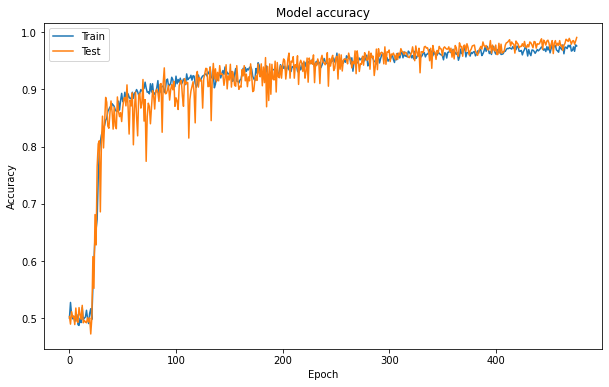

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

**Loss Graph**

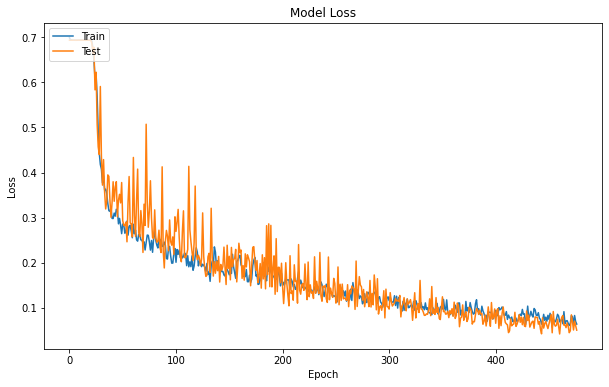

In [ ]:
# plt.figure(figsize=(10,6))
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()